In [1]:
import os
import numpy as np

from dusty import util as U
from dusty import data as D

In [2]:
import astropy.units as u
from astropy.cosmology import Planck13

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

## examine the NIHAO SEDs

In [4]:
# get data
NH = D.Nihao()

z_orig = 0.022229 # this corresponds to 100Mpc
z_new = 0.4

filters = U.lsst()

In [5]:
# [3728., 4861., 5007., 6564., 6585.27, 6718.29, 6732.67, 9068.60, 9531.100, 9545.969]
w_ems = [3730., 4861., 5007., 6564., 6585.27, 6718.29, 6732.67, 9068.60, 9545.969]
em_masks = [(3720, 3740), (4850, 4870), (4990, 5025), (6525., 6600.), (6700., 6770.), (9040., 9095.), (9520., 9580.)]

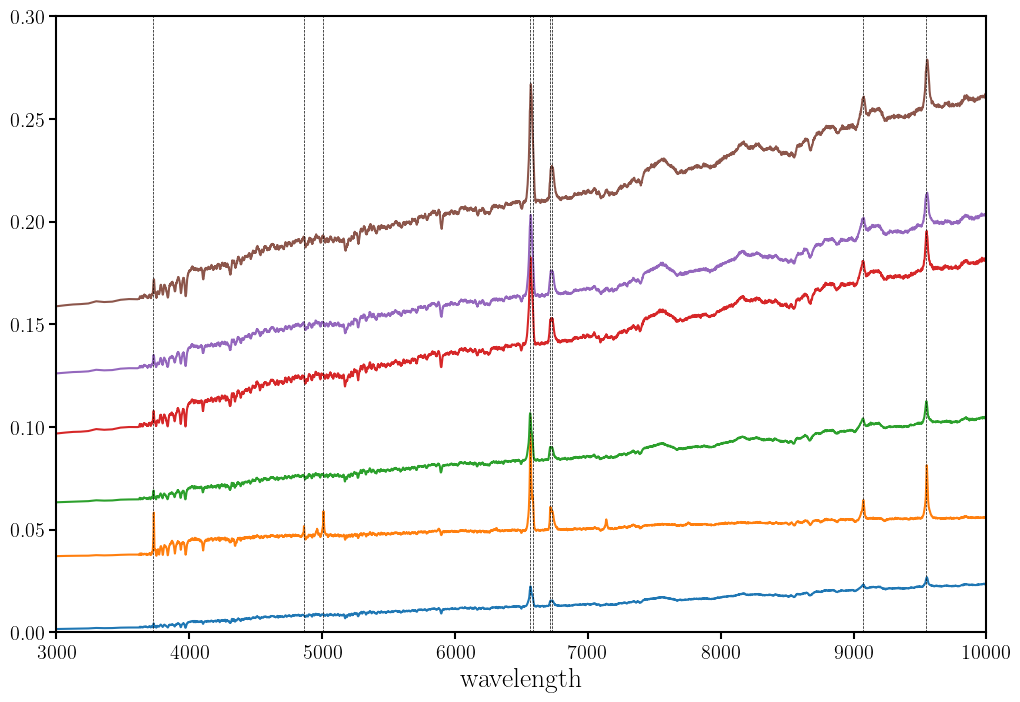

In [6]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)

for ii, igal in enumerate(np.arange(59, 65)): 
    sub.plot(NH.wave, NH.seds_unatten[10*igal] + ii*0.03)
    
for w_em in w_ems: 
    sub.axvline(w_em, color='k', linestyle='--', lw=0.5)
    
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylim(0., 0.3)
plt.show()

## mask emission lines

In [7]:
wlim = np.ones(len(NH.wave)).astype(bool)
for em_mask in em_masks: 
    wlim &= ~((NH.wave > em_mask[0]) & (NH.wave < em_mask[1]))

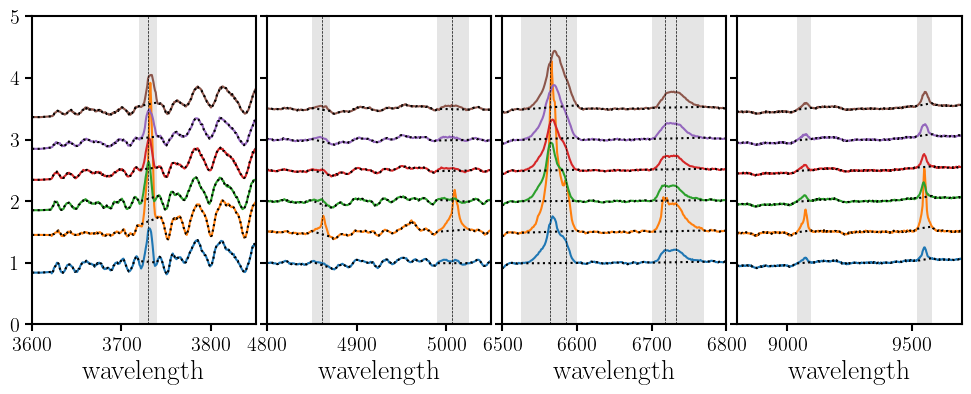

In [8]:
fig = plt.figure(figsize=(12,4))

for i, wbin in enumerate([(3600., 3850.), (4800., 5050.), (6500., 6800.), (8800., 9700.)]): 
    
    sub = fig.add_subplot(1,4,i+1)
    
    for _i, igal in enumerate(np.arange(59, 65)):             
        norm = np.median(NH.seds_unatten[10*igal][wlim & (NH.wave > wbin[0]) & (NH.wave < wbin[1])])
        
        sub.plot(NH.wave, NH.seds_unatten[10*igal]/norm + 0.5 * _i)
        sub.plot(NH.wave[wlim], NH.seds_unatten[10*igal][wlim]/norm + 0.5 * _i, c='k', ls=':')
    
    for w_em, em_mask in zip(w_ems, em_masks): 
        sub.axvline(w_em, color='k', linestyle='--', lw=0.5)
        sub.fill_between([em_mask[0], em_mask[1]], [0., 0.], [100., 100.], color='k', alpha=0.1, edgecolor='none')

    sub.set_xlabel('wavelength', fontsize=20)
    sub.set_xlim(wbin[0], wbin[1])
    sub.set_ylim(0., 5.)
    if i > 0: sub.set_yticklabels([])
        
fig.subplots_adjust(wspace=0.05)
plt.show()

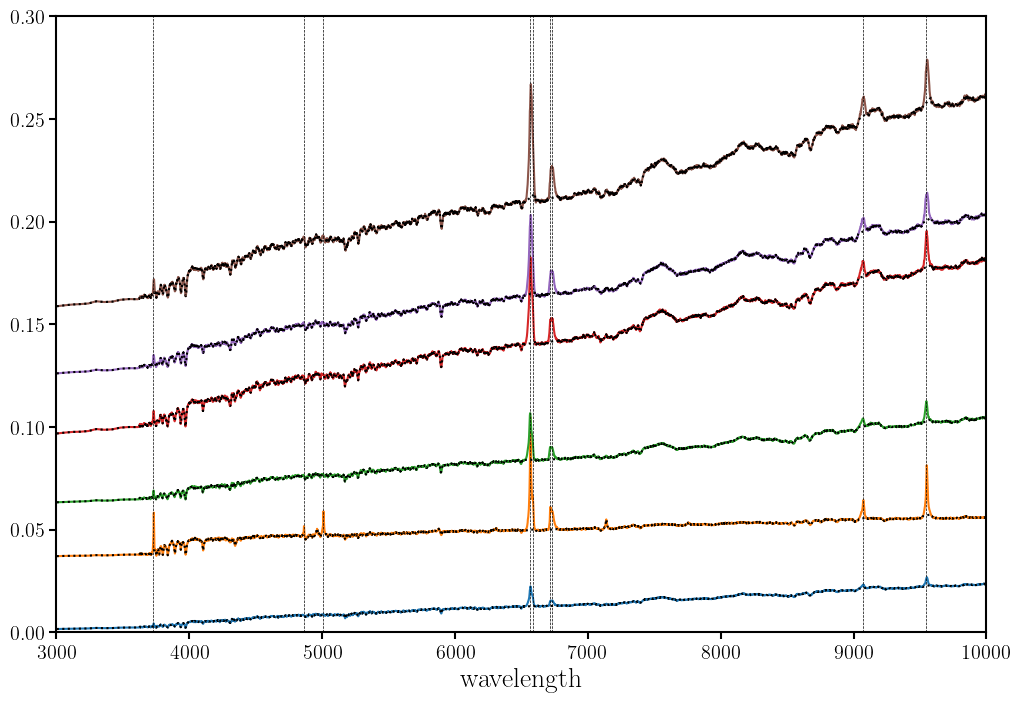

In [9]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)

for ii, igal in enumerate(np.arange(59, 65)): 
    sub.plot(NH.wave, NH.seds_unatten[10*igal] + ii*0.03)
    sub.plot(NH.wave[wlim], NH.seds_unatten[10*igal][wlim] + ii*0.03, c='k', ls=':')
    
for w_em in w_ems: 
    sub.axvline(w_em, color='k', linestyle='--', lw=0.5)
    
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylim(0., 0.3)
plt.show()

## now lets generate maggies
First dry-redshift the fluxes

janksy to flux conversion: 
https://wikimedia.org/api/rest_v1/media/math/render/svg/b0365909abd924831a2bd1852bd560018bc99678

In [10]:
# original fluxes are calculate at 100 Mpc or z = 0.022229
wavez0 = NH.wave*(1+z_orig)

# convert to flux to f_lambda --- f_nu = 3.34*10^4 lambda^2 f_lambda; f_nu is originally in Janskies
fl0 = NH.seds / 3.34e4 / wavez0**2 # erg/cm^2/s/A 
fl_unatten0 = NH.seds_unatten / 3.34e4 / wavez0**2 # erg/cm^2/s/A 

In [11]:
# dry redshifting
wavez = NH.wave * (1 + z_new)
fl = (fl0 * ((100. * u.Mpc) / Planck13.luminosity_distance(z_new).to(u.Mpc))**2).value
fl_unatten = (fl_unatten0 * ((100. * u.Mpc) / Planck13.luminosity_distance(z_new).to(u.Mpc))**2).value

In [12]:
fl0/fl

array([[500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662],
       [500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662],
       [500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662],
       ...,
       [500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662],
       [500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662],
       [500.93130662, 500.93130662, 500.93130662, ..., 500.93130662,
        500.93130662, 500.93130662]])

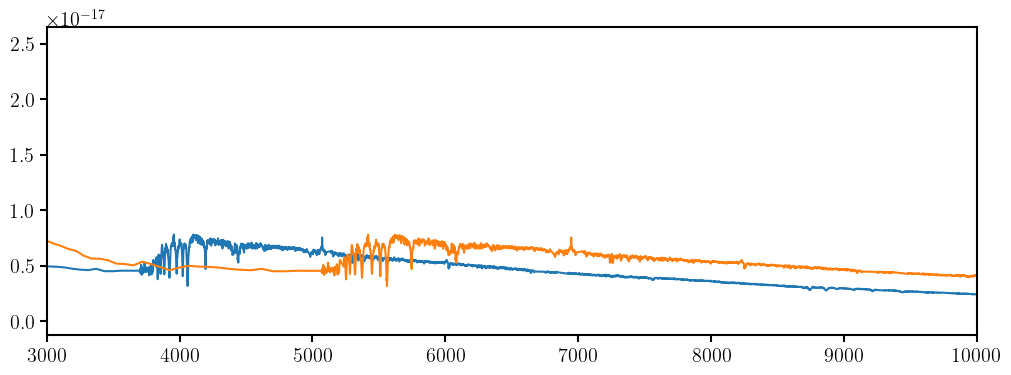

In [13]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)
sub.plot(wavez0[wlim], fl0[0][wlim]) 
sub.plot(wavez[wlim], 500*fl[0][wlim]) 
sub.set_xlim(3e3, 1e4)
plt.show()

In [14]:
_maggies = filters.get_ab_maggies(fl[:,wlim], wavelength=wavez[wlim])
maggies = np.array([np.array(list(arr)) for arr in _maggies.as_array()]) * 1e9

_maggies_unatten = filters.get_ab_maggies(fl_unatten[:,wlim], wavelength=wavez[wlim])
maggies_unatten = np.array([np.array(list(arr)) for arr in _maggies_unatten.as_array()]) * 1e9

In [15]:
_maggies0 = NH.maggies(z_orig, filters=filters)
print(_maggies0 / maggies)

[[ 492.27903384  644.01058786  377.35222454  342.72582016  320.11491569
   307.7381074 ]
 [ 490.36114261  643.74754138  376.8563744   342.45566201  320.11648541
   307.5493028 ]
 [ 493.28416246  643.08355834  376.41547521  342.25509642  319.68991954
   307.13092856]
 ...
 [1631.48038539 1637.14294504  746.60930423  585.95824545  556.49670707
   560.52036752]
 [1624.40826658 1626.74863842  742.94418467  583.83693378  553.11618238
   558.35889682]
 [1565.58998087 1575.25070103  723.52769159  570.99827254  544.58395869
   550.20096414]]


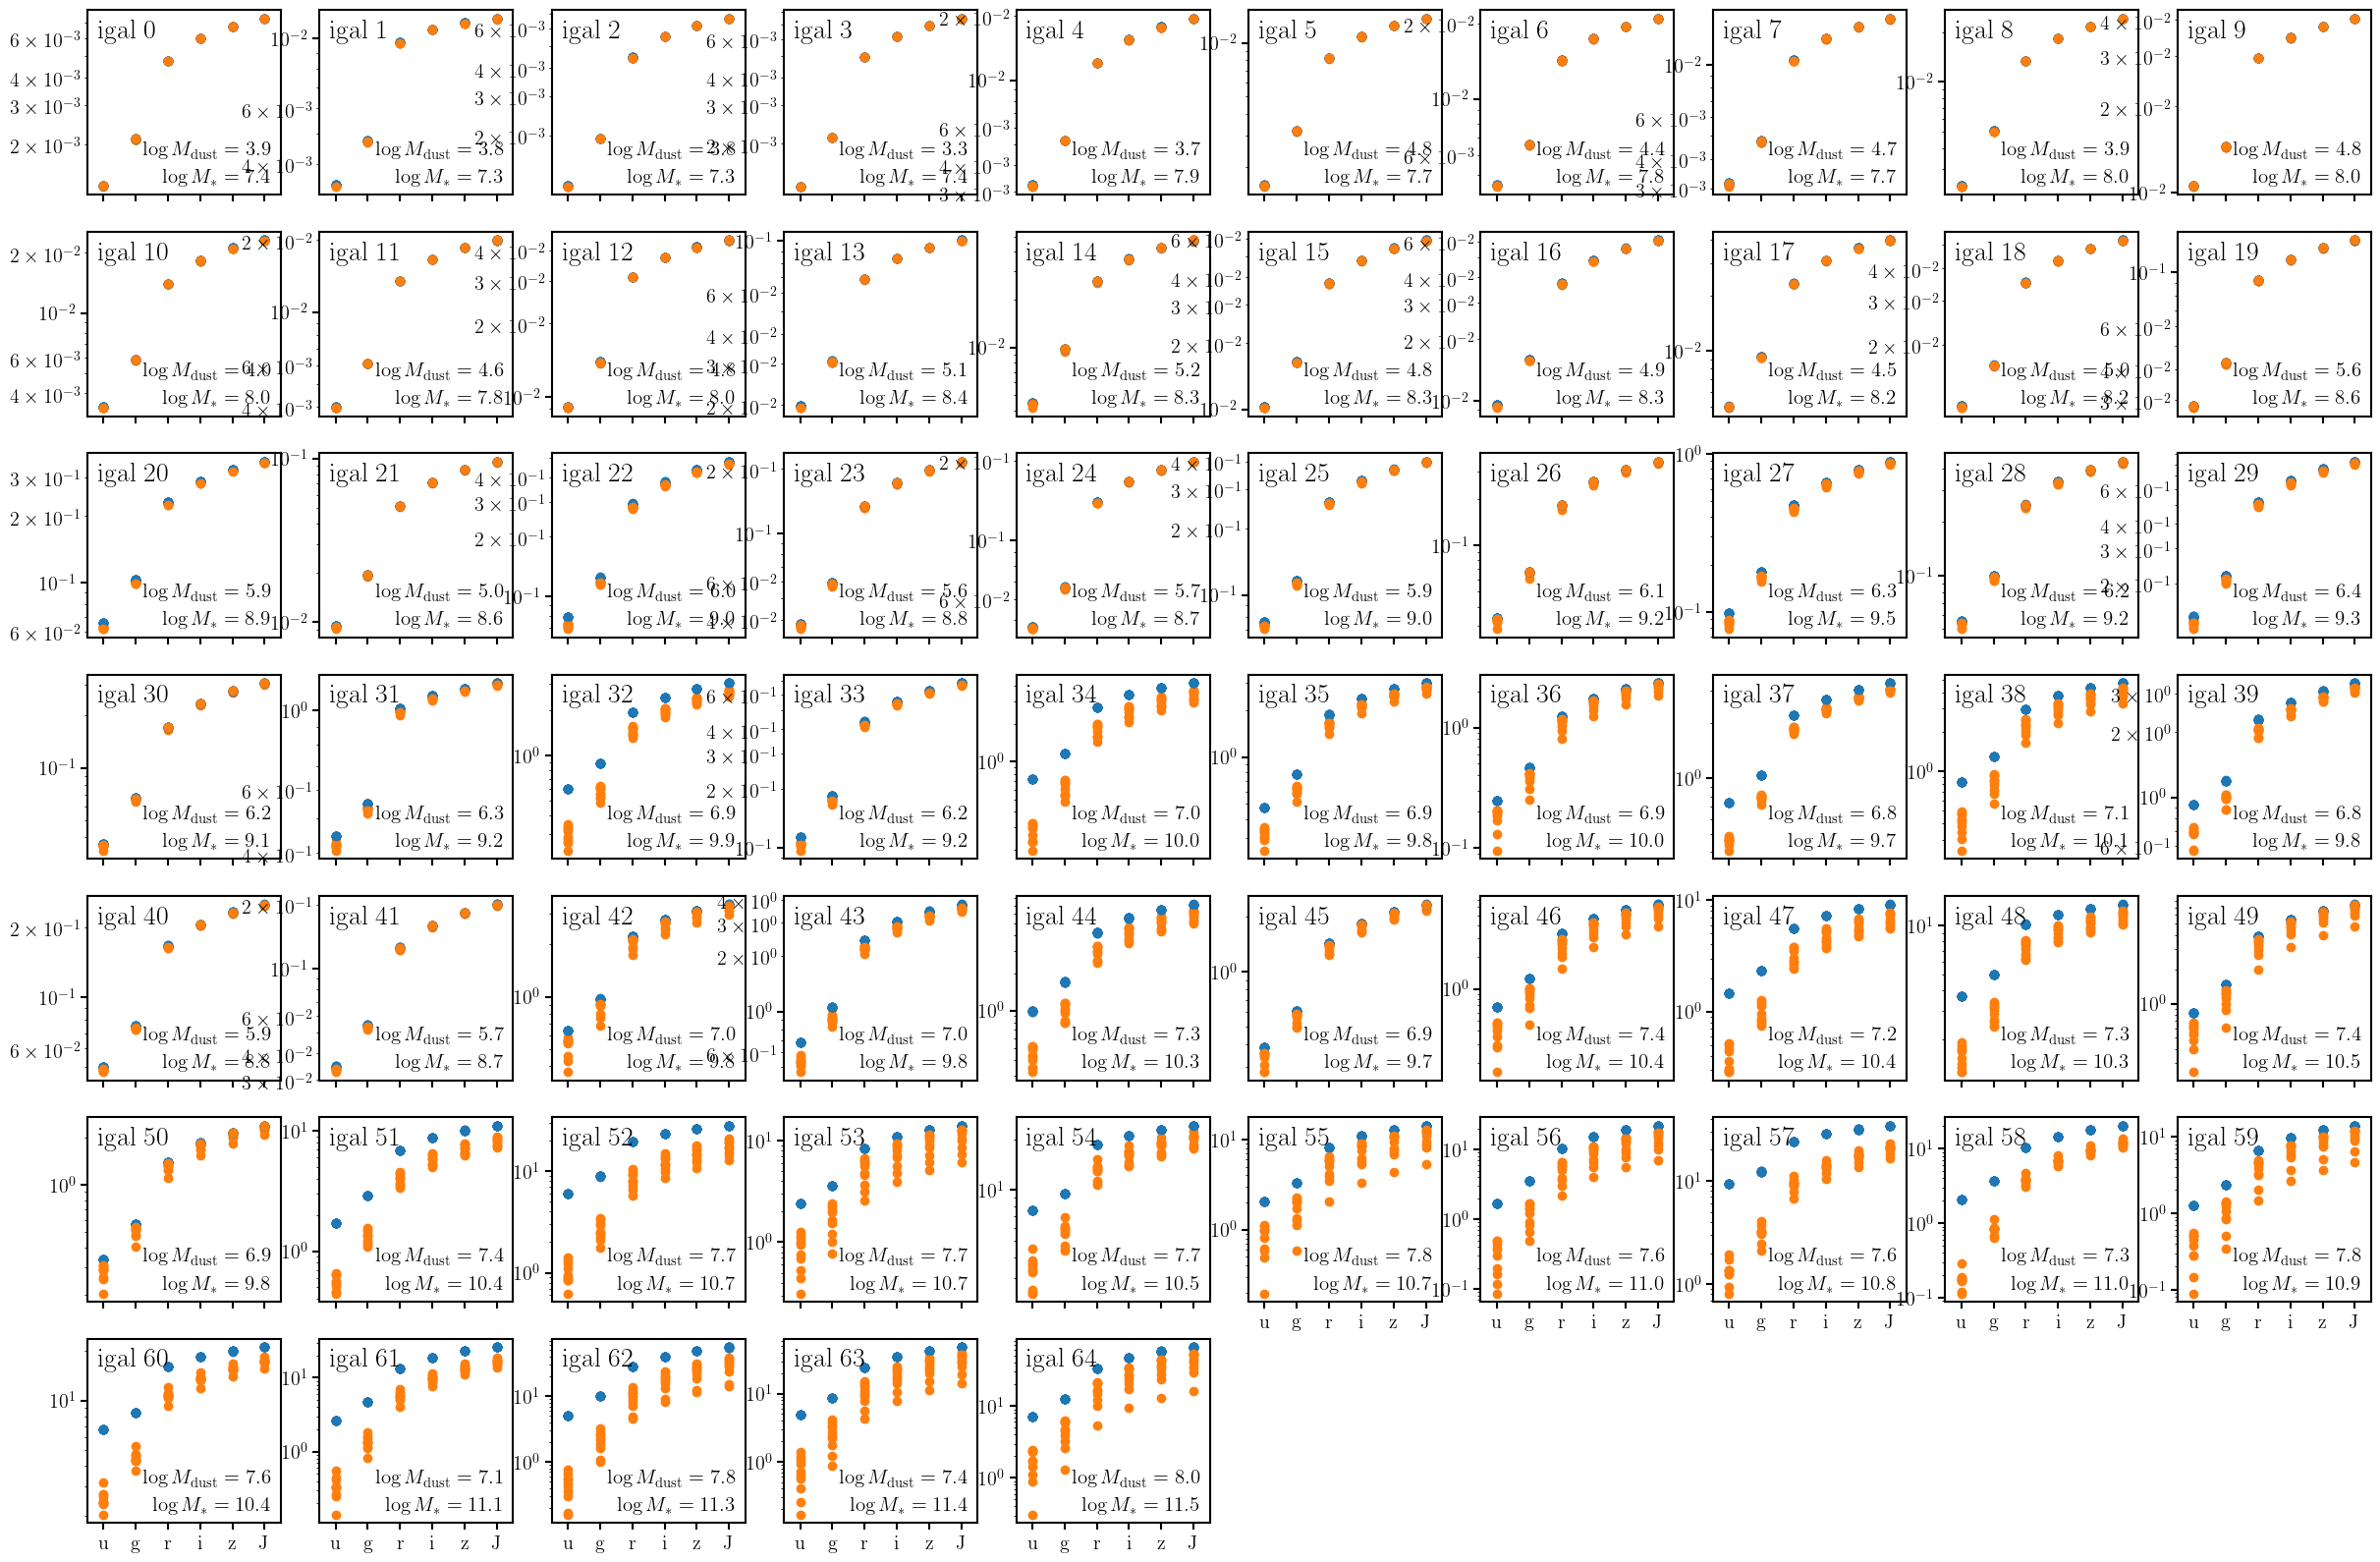

In [16]:
fig = plt.figure(figsize=(30,20))
for igal in range(65): 
    sub = fig.add_subplot(7, 10, igal+1)
    
    for ii in range(10): 
        sub.scatter(range(6), maggies_unatten[10*igal+ii], c='C0')
        sub.scatter(range(6), maggies[10*igal+ii], c='C1')
    
    sub.text(0.05, 0.95, 'igal %i' % igal, transform=sub.transAxes, ha='left', va='top', fontsize=20)
    sub.text(0.95, 0.05, r'$\log M_* = %.1f$' % np.log10(NH.prop['stellar_mass'])[10*igal], 
             transform=sub.transAxes, ha='right', va='bottom', fontsize=15)
    sub.text(0.95, 0.20, r'$\log M_{\rm dust} = %.1f$' % np.log10(NH.prop['dust_mass'])[10*igal], 
             transform=sub.transAxes, ha='right', va='bottom', fontsize=15)
    
    sub.set_xticks(np.arange(6))
    if igal < 55: sub.set_xticklabels([])
    else: sub.set_xticklabels(['u', 'g', 'r', 'i', 'z', 'J'])
    sub.set_xlim(-0.5, 5.5)
    sub.set_yscale('log')
    
plt.show()

In [17]:
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.maggies.npy', maggies)
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.maggies_nodust.npy', maggies_unatten)

# apply noise
We'll use noise levels from Figure 1 of [Graham et al. (2018)](https://iopscience.iop.org/article/10.3847/1538-3881/aa99d4/pdf)

In [18]:
mag_arr_u = np.array([21.000535514065614, 21.787138737190894, 22.396252517195023, 22.942008289311474, 23.55145676560661,  24.07224419441392,  24.68269675958208,  25.34549582466377,  26.124702259757793])
sig_mag_u = np.array([0.008311345646437929, 0.010422163588390432, 0.014116094986807326, 0.018865435356200444, 0.027836411609498624, 0.03891820580474925, 0.06372031662269123, 0.1138522427440633, 0.19934036939313982])

mag_arr_g = np.array([21.013053155349287, 21.774219460358015, 22.852543970725232, 23.62659608293774,  24.36272710537913,  25.188188567890354, 25.87488494814997,  26.511611172162194, 26.983733760257046, 27.40471475508599])
sig_mag_g = np.array([0.005672823218997314, 0.0067282321899735376, 0.008311345646437929, 0.012532981530342935, 0.018865435356200444, 0.03364116094986802, 0.060554089709762504, 0.09960422163588387, 0.1434036939313984, 0.1808707124010554])

mag_arr_r = np.array([21.013053155349287, 22.002515800454074, 23.004730374246236, 24.007112296183905, 24.946504376154007, 25.74706443461429,  26.268521256003616])
sig_mag_r = np.array([0.005672823218997314, 0.006200527704485426,  0.007783641160949817,  0.012005277044854823,  0.023087071240105506,  0.045250659630606815,  0.06688654353562001])

mag_arr_i = np.array([21.013053155349287, 22.002549270083172, 22.624214161000076, 23.157151065170947, 23.829823670837357, 24.210741519632727, 24.579074787886228, 24.998549649405636])
sig_mag_i = np.array([0.005672823218997314, 0.0067282321899735376, 0.008311345646437929, 0.0109498680738786, 0.01675461741424794, 0.022559366754617338, 0.029947229551451127, 0.043667546174142424])

mag_arr_z = np.array([21.02573814477846,  21.634684576637085, 22.26903445698316,  22.916270144533016, 23.728912739098664, 24.339064077604917, 24.80981441090664,  25.319489922852505])
sig_mag_z = np.array([0.005672823218997314, 0.0067282321899735376, 0.008311345646437929, 0.013060686015831102, 0.02572559366754612, 0.04577836411609493, 0.06794195250659626, 0.1038258575197889])

mag_arr_y = np.array([21.01322050349479,  21.520854368065514, 22.193694321877423, 22.701796761255558, 23.210300836182903, 23.770448548812666, 24.26804152465317,  24.893555422916656])
sig_mag_y = np.array([0.008311345646437929, 0.012005277044854823, 0.020448548812664835, 0.03153034300791552, 0.04894459102902371, 0.08060686015831131, 0.1259894459102902, 0.18825857519788916])

noise_mag = [mag_arr_u, mag_arr_g, mag_arr_r, mag_arr_i, mag_arr_z, mag_arr_y]
noise_sig = [sig_mag_u, sig_mag_g, sig_mag_r, sig_mag_i, sig_mag_z, sig_mag_y]

In [19]:
def mag2flux(mag): 
    ''' convert magnitudes to flux in nanomaggies
    '''
    return 10**(0.4 * (22.5 - mag)) 

def sigma_mag2flux(sigma_mag, mag): 
    ''' convert sigma_mag to sigma_flux
    '''
    flux = mag2flux(mag)
    return np.abs(flux) * np.abs(-0.4 * np.log(10) * sigma_mag)

In [20]:
maggies_noise, maggies_nodust_noise = [], [] 
sig_maggies, sig_maggies_nodust = [], []
for igal in range(65): 
    for iang in range(10): 
        mag = 22.5 - 2.5 * np.log10(maggies[10*igal+iang])
        mag_nodust = 22.5 - 2.5 * np.log10(maggies_unatten[10*igal+iang])

        sig_mag, sig_mag_nodust = [], []
        for i in range(6): 
            sig_mag.append(np.interp(mag[i], noise_mag[i], noise_sig[i]))
            sig_mag_nodust.append(np.interp(mag_nodust[i], noise_mag[i], noise_sig[i]))
        sig_mag = np.array(sig_mag)
        sig_mag_nodust = np.array(sig_mag_nodust)
        
        if igal > 62:
            print('mag', mag_nodust)
            print('sig', sig_mag_nodust)
            
                
        sig_maggies.append(sigma_mag2flux(sig_mag, mag))
        sig_maggies_nodust.append(sigma_mag2flux(sig_mag_nodust, mag_nodust))
    
        maggies_noise.append(maggies[10*igal+iang] + sig_maggies[-1])
        maggies_nodust_noise.append(maggies_unatten[10*igal+iang] + sig_maggies_nodust[-1]) 

mag [20.78350288 20.14697275 19.04339304 18.65589398 18.43161616 18.29255425]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.78355298 20.14708646 19.04339357 18.65611883 18.43152211 18.29233411]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.784004   20.1477369  19.04446829 18.65679139 18.43129545 18.29247842]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.78362652 20.14740388 19.04357962 18.65593436 18.43240095 18.29219483]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.78280028 20.14478881 19.04122397 18.65423793 18.43206808 18.29188166]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.78315039 20.14611772 19.04258905 18.65499408 18.43240442 18.29264223]
sig [0.00831135 0.00567282 0.00567282 0.00567282 0.00567282 0.00831135]
mag [20.78240341 20.14397925 19.0403534  18.65305933 18.43131546 18.29203093]
sig [0.00831135 0.0056

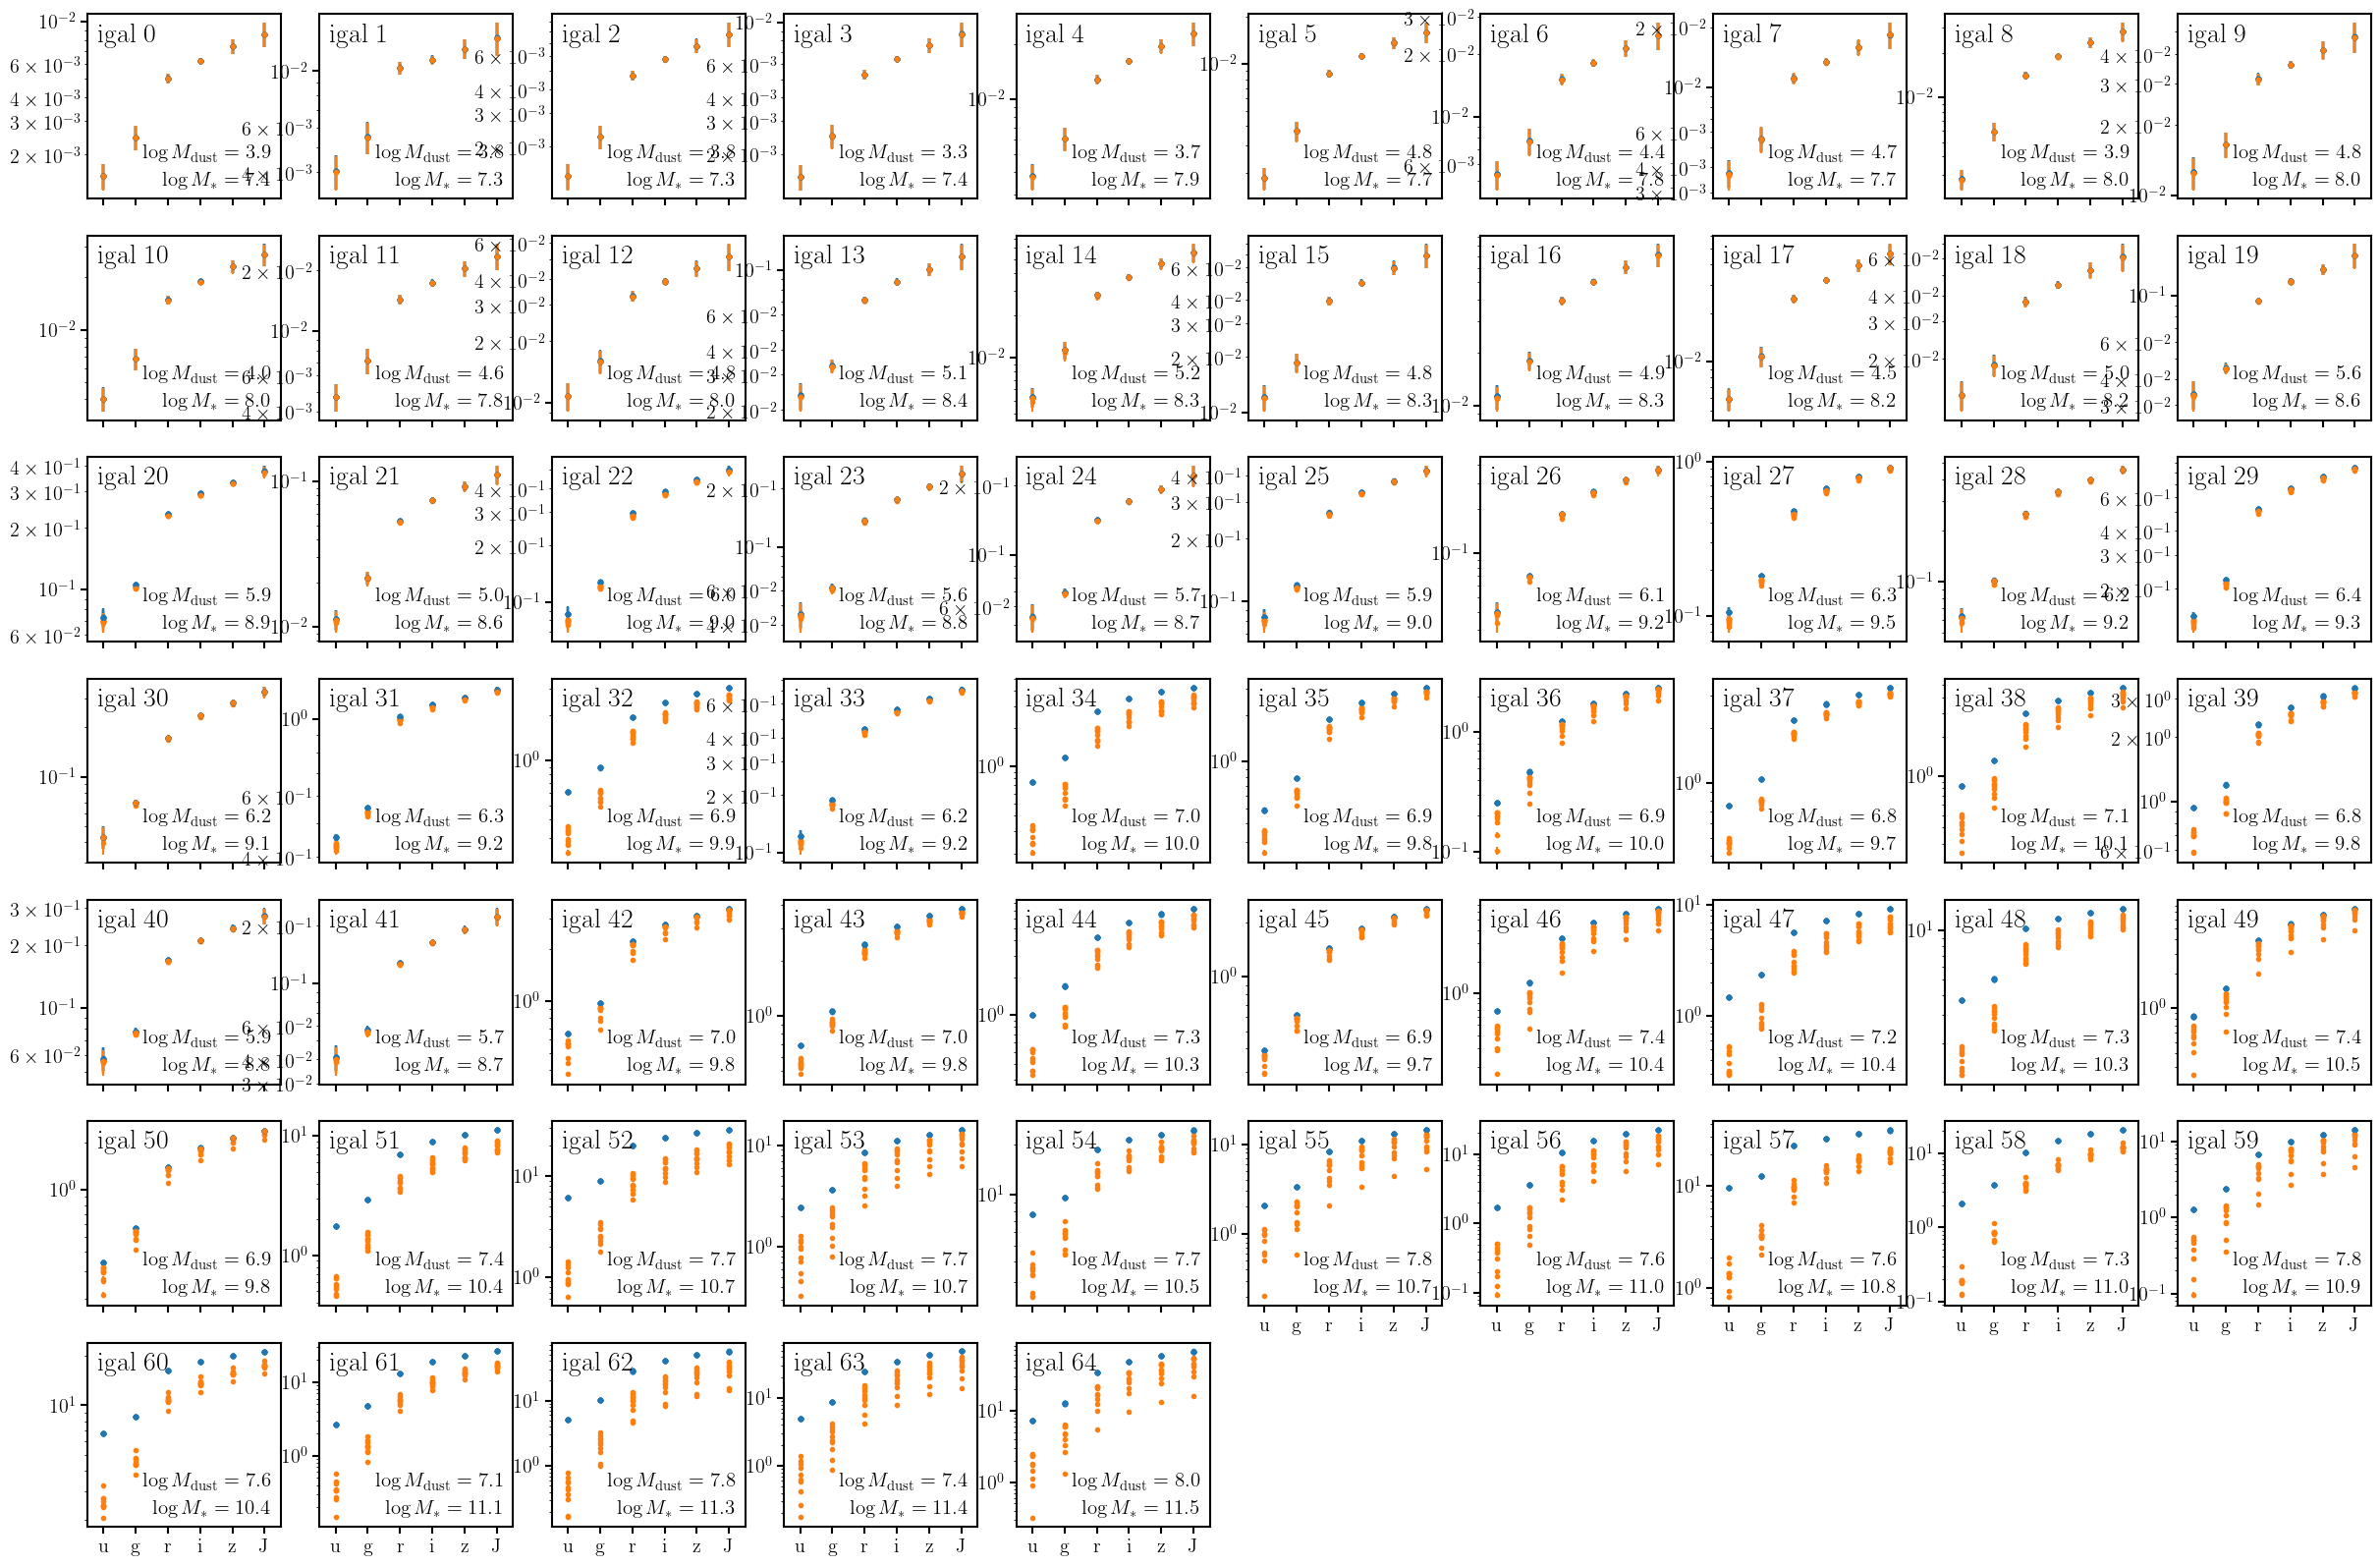

In [21]:
fig = plt.figure(figsize=(30,20))
for igal in range(65): 
    sub = fig.add_subplot(7, 10, igal+1)
    
    for ii in range(10): 
        sub.errorbar(np.arange(6), maggies_nodust_noise[10*igal+ii], yerr=sig_maggies_nodust[10*igal+ii], fmt='.C0')
        sub.errorbar(np.arange(6), maggies_noise[10*igal+ii], yerr=sig_maggies[10*igal+ii], fmt='.C1')
    
    sub.text(0.05, 0.95, 'igal %i' % igal, transform=sub.transAxes, ha='left', va='top', fontsize=20)
    sub.text(0.95, 0.05, r'$\log M_* = %.1f$' % np.log10(NH.prop['stellar_mass'])[10*igal], 
             transform=sub.transAxes, ha='right', va='bottom', fontsize=15)
    sub.text(0.95, 0.20, r'$\log M_{\rm dust} = %.1f$' % np.log10(NH.prop['dust_mass'])[10*igal], 
             transform=sub.transAxes, ha='right', va='bottom', fontsize=15)
    
    sub.set_xticks(np.arange(6))
    if igal < 55: sub.set_xticklabels([])
    else: sub.set_xticklabels(['u', 'g', 'r', 'i', 'z', 'J'])
    sub.set_xlim(-0.5, 5.5)
    sub.set_yscale('log')
    
plt.show()

In [22]:
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.maggies_noisy.npy', maggies_noise)
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.maggies_nodust_noisy.npy', maggies_nodust_noise)
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.sig_maggies.npy', sig_maggies)
np.save('/Users/chahah/data/dusty/nihao_lsst.v3.z0p4.sig_maggies_nodust.npy', sig_maggies_nodust)